# 1. Task Aligned Generative Meta-learning for Zero-shot Learning (TGMZ)
In this project, a novel method of zero-shot learning as described [here](https://ojs.aaai.org/index.php/AAAI/article/download/17057/16864) is attempted to be implemented(*). The paper was published in [AAAI-21](https://aaai.org/Conferences/AAAI-21/).

(*): The paper uses certain architectures that do not have public implementations:
* a type of generative adversarial network called Meta-conditional Generative Adversarial Network (MGAN)
* a type of autoencoder called Task-adversarial AutoEncoder (TAE)

Moreover, the papers uses four benchmark datasets: AWA1, AWA2, aPY and CUB.
* [AWA1](https://paperswithcode.com/dataset/awa-1) is retracted due to copyright issues.
* [AWA2](https://paperswithcode.com/dataset/awa2-1) is available.
* [aPY](https://paperswithcode.com/dataset/apy) has parts from Yahoo and Pascal, Pascal images are unavailable.
* [CUB](https://paperswithcode.com/dataset/cub-200-2011) is entirely unavailable.

Thus,
1. We will be working with AWA2.
2. We will be using approximations of the architectures to the top.

Therefore, we will not be able to perfectly replicate the paper's results.

In [60]:
# Imports
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import defaultdict
from time import time
from tqdm import tqdm
from scipy import io as sio
from torch.utils.data import DataLoader

# Global constants
RANDOM_SEED = 100
DATASET = 'AWA2'
DEVICE = 'cuda'  # one of {'cpu', 'cuda'}
NUMBER_OF_TASK_BATCHES = 1024
DATA_LOADER_BATCH_SIZE = 16
N_WAY = 8
K_SHOT = 5

# Set RNG seed
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

# 2. Organizing Data
We will be working with the AWA2 dataset. The paper uses "visual features" instead of the original images themselves. AWA2 has an artifact that contains image feature vectors extracted with a pretrained ResNet-101 model and corresponding attribute, class data.

Disclaimer:
* Data loading is adapted from [this](https://gist.github.com/iclr2021-classnorm/dd0e89521be029dac63d1d8b0a2d9401) gist.

In [61]:
# Download the dataset
%%bash
if [ -d "./data" ]
then
  echo "./data directory already exists."
else
  wget -q "http://datasets.d2.mpi-inf.mpg.de/xian/xlsa17.zip"
  unzip -q xlsa17.zip -d ./data
  echo "Downloaded the feature/label set."
fi

./data directory already exists.


In [62]:
# Load data
DATA_DIR = f'./data/xlsa17/data/{DATASET}'
# Load MATLAB files
data = sio.loadmat(f'{DATA_DIR}/res101.mat')
attrs_mat = sio.loadmat(f'{DATA_DIR}/att_splits.mat')
# Read classes and attributes
all_classes = [x[0] for x in attrs_mat['allclasses_names'].squeeze()]
attrs = attrs_mat['att'].T
# Read features and labels with one row per image
feats = data['features'].T.astype(np.float32)
labels = data['labels'].squeeze() - 1  # MATLAB 1-index to Python 0-index
images = [x[0].split('/')[-1] for x in data['image_files'].squeeze()]
# Get indices of the images that belong to a dataset
train_idx = attrs_mat['trainval_loc'].squeeze() - 1
test_seen_idx = attrs_mat['test_seen_loc'].squeeze() - 1
test_unseen_idx = attrs_mat['test_unseen_loc'].squeeze() - 1
test_idx = np.array(test_seen_idx.tolist() + test_unseen_idx.tolist())
# Get indices of seen and unseen classes
seen_classes = sorted(np.unique(labels[test_seen_idx]))
unseen_classes = sorted(np.unique(labels[test_unseen_idx]))

In [63]:
# Generate test dataset
ds_test = [(feats[idx], attrs[labels[idx]], labels[idx], images[idx], all_classes[labels[idx]]) for idx in test_idx]

# Read training and validation classes
with open(f'{DATA_DIR}/trainclasses1.txt') as fp:
  training_class_names = fp.readlines()
  training_class_names = set([n.strip() for n in training_class_names])
with open(f'{DATA_DIR}/valclasses1.txt') as fp:
  validation_class_names = fp.readlines()
  validation_class_names = set([n.strip() for n in validation_class_names])

# Generate train datasets
# We will use this to generate maps of classes to samples
ds_train = [(feats[idx], attrs[labels[idx]], labels[idx], images[idx], all_classes[labels[idx]]) for idx in train_idx]
train_samples = defaultdict(list)
validate_samples = defaultdict(list)
for sample in ds_train:
  if sample[4] in training_class_names:
    train_samples[sample[2]].append(sample)
  else:
    validate_samples[sample[2]].append(sample)

In [64]:
def generate_task(train_map, validate_map, N, K):
  # From each set we pick N classes and from each class we pick K samples
  assert N <= len(train_map.keys()) and N <= len(validate_map.keys())
  train_keys = random.sample(train_map.keys(), N)
  validate_keys = random.sample(validate_map.keys(), N)
  train_samples = list()
  validate_samples = list()
  for key in train_keys:
    assert K <= len(train_map[key])
    train_samples += random.sample(train_map[key], K)
  for key in validate_keys:
    assert K <= len(validate_map[key])
    validate_samples += random.sample(validate_map[key], K)
  return train_samples, validate_samples

In [65]:
# Create a actual datasets and dataloaders
task_set = []
for i in range(NUMBER_OF_TASK_BATCHES):
  t_sam, v_sam = generate_task(train_samples, validate_samples, N_WAY, K_SHOT)
  feats = np.stack([x[0] for x in t_sam] + [x[0] for x in v_sam])
  attrs = np.stack([x[1] for x in t_sam] + [x[1] for x in v_sam])
  labels = np.stack([x[2] for x in t_sam] + [x[2] for x in v_sam])
  task_set.append((torch.Tensor(feats), torch.Tensor(attrs), torch.Tensor(labels).to(torch.int64)))

task_loader = DataLoader(task_set, batch_size=DATA_LOADER_BATCH_SIZE, shuffle=True)

test_set = [(
    torch.Tensor(x[0]), 
    torch.Tensor([x[1]]), 
    torch.Tensor([x[2]]).to(torch.int64), 
    F.one_hot(torch.Tensor([x[2]]).to(torch.int64), num_classes=len(all_classes)).squeeze()
    ) for x in ds_test]
test_loader = DataLoader(test_set, batch_size=DATA_LOADER_BATCH_SIZE)

# 3. Methodology

>[TGMZ] training procedure consists of two phases: task distribution alignment and task-aligned generative zero-shot learning. The former phase aligns the diverse sampled tasks to a unified task distribution to ease the biased optimization. The latter phase synthesizes instances in the aligned distribution conditioned on attribute vectors and uses meta-learner to train the model.



## 3.1. Task Distribution Alignment

In this phase, we train an autoencoder to align the distribution of tasks to a unified distribution. The paper uses a special type of autoencoder called "Task-adversarial AutoEncoder". We will be using a standard autoencoder modified to our needs.

In [66]:
class Autoencoder(nn.Module):
  def __init__(self, input_dim):
    assert input_dim > 1024

    super(Autoencoder, self).__init__()
    
    # Encoder network
    self.encoder = nn.Sequential(
        nn.Linear(input_dim, 1024),
        nn.ReLU(True),
        nn.Linear(1024, 256),
        nn.ReLU(True),
        nn.Linear(256, 43)  # Adds up to 128 with attr vector
    )
    # Decoder network
    self.decoder = nn.Sequential(
        nn.Linear(43, 256),
        nn.ReLU(True),
        nn.Linear(256, 1024),
        nn.ReLU(True),
        nn.Linear(1024, input_dim)
    )

  def forward(self, x):
    """
    We want to return the encoding as well as the result
    """
    e = self.encoder(x)
    y = self.decoder(e)
    return y, e

In [67]:
def train_autoencoder(model, criterion, optimizer, epochs, dataloader, verbose=True):
  loss_history = [] 
  for epoch in range(epochs):
    for i, data in enumerate(dataloader, 0):  
      # Our batch:
      inputs, attrs, labels = data
      inputs = inputs.to(DEVICE)
      labels = labels.to(DEVICE)
      # zero the gradients as PyTorch accumulates them
      optimizer.zero_grad()
      # Obtain the scores
      outputs, encodings = model(inputs)
      # Calculate loss
      loss = criterion(outputs.to(DEVICE), inputs)
      # Backpropagate
      loss.backward()
      # Update the weights
      optimizer.step()
      loss_history.append(loss.item())
    
    if verbose: print(f'Epoch {epoch} / {epochs}: avg. loss of last 5 iterations {np.sum(loss_history[:-6:-1])/5}')

  return loss_history

In [68]:
# Train the autoencoder
input_dim = 2048  # Feature vector size

autoencoder = Autoencoder(input_dim)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3, weight_decay=1e-5)

autoencoder = autoencoder.to(DEVICE)
epochs = 100
autoencoder_loss_history = train_autoencoder(autoencoder, criterion, optimizer, epochs, task_loader)

Epoch 0 / 100: avg. loss of last 5 iterations 0.43541717529296875
Epoch 1 / 100: avg. loss of last 5 iterations 0.3171946585178375
Epoch 2 / 100: avg. loss of last 5 iterations 0.2610952377319336
Epoch 3 / 100: avg. loss of last 5 iterations 0.2343302071094513
Epoch 4 / 100: avg. loss of last 5 iterations 0.21191810071468353
Epoch 5 / 100: avg. loss of last 5 iterations 0.19477333426475524
Epoch 6 / 100: avg. loss of last 5 iterations 0.19137744307518006
Epoch 7 / 100: avg. loss of last 5 iterations 0.17933377325534822
Epoch 8 / 100: avg. loss of last 5 iterations 0.17125119566917418
Epoch 9 / 100: avg. loss of last 5 iterations 0.16759904325008393
Epoch 10 / 100: avg. loss of last 5 iterations 0.16109607815742494
Epoch 11 / 100: avg. loss of last 5 iterations 0.15652016103267669
Epoch 12 / 100: avg. loss of last 5 iterations 0.15166289806365968
Epoch 13 / 100: avg. loss of last 5 iterations 0.14723241925239564
Epoch 14 / 100: avg. loss of last 5 iterations 0.1458130568265915
Epoch 15 

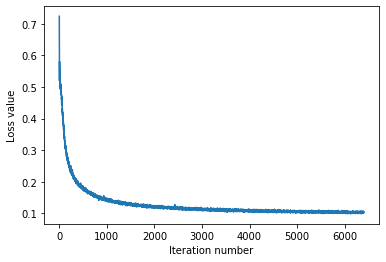

In [69]:
# Plot autoencoder loss history
plt.plot(autoencoder_loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

## 3.2. Generative Zero-shot Learning

In this phase, we train a modified GAN together with a classifier. The paper uses a special type of autoencoder called "Meta-conditional Generative Adversarial Network". We will be using a standard GAN modified to our needs.

### 3.2.1. GAN Training
We will cut some corners and train GAN before the classifier.

In [70]:
class Generator(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(Generator, self).__init__()
    self.model = nn.Sequential(
        nn.Linear(input_dim, 512),
        nn.LeakyReLU(0.1, True),
        nn.Linear(512, 2048),
        nn.LeakyReLU(0.1, True),
        nn.Linear(2048, output_dim),
        nn.Sigmoid()
    )

  def forward(self, a, z):
    x = torch.cat((a, z), 2)
    y = self.model(x)
    return y


class Discriminator(nn.Module):
  def __init__(self, input_dim):
    super(Discriminator, self).__init__()
    self.model = nn.Sequential(
        nn.Linear(input_dim, 512),
        nn.LeakyReLU(0.1, True),
        nn.Linear(512, 1),
        nn.Sigmoid()
    )

  def forward(self, a, e):
    x = torch.cat((a, e), 2)
    y = self.model(x)
    return y

In [71]:
def train_gan(
    autoencoder, 
    gen, gen_criterion, gen_optimizer, 
    disc, disc_criterion, disc_optimizer,
    epochs, dataloader, verbose=True):
  disc_loss_history = [] 
  gen_loss_history = []
  for epoch in range(epochs):
    for i, data in enumerate(dataloader, 0):
      # Our batch:
      inputs, attrs, labels = data
      inputs = inputs.to(DEVICE)
      attrs = attrs.to(DEVICE)
      labels = labels.to(DEVICE)
      # Obtain the encodings
      with torch.no_grad():
        outputs, encodings = autoencoder(inputs)

      encodings = encodings.to(DEVICE)
      inp_shape = encodings.shape[:2]

      real_labels = torch.ones(*inp_shape, 1).to(DEVICE)
      fake_labels = torch.zeros(*inp_shape, 1).to(DEVICE)

      if not disc_loss_history or (gen_loss_history and gen_loss_history[-1] <= disc_loss_history[-1]):
        # Train the discriminator
        real_outputs = disc(attrs, encodings)
        noise = ((torch.rand(encodings.shape) - 0.5) / 0.5).to(DEVICE)
        fake_encodings = gen(attrs, noise)
        fake_outputs = disc(attrs, fake_encodings)

        disc_outputs = torch.cat((real_outputs, fake_outputs), 0)
        disc_targets = torch.cat((real_labels, fake_labels), 0)

        disc_loss = disc_criterion(disc_outputs, disc_targets)
        disc_optimizer.zero_grad()
        disc_loss.backward()
        disc_optimizer.step()

        disc_loss_history.append(disc_loss.item())

      if not gen_loss_history or (disc_loss_history and disc_loss_history[-1] <= gen_loss_history[-1]):
        # Train the generator
        noise = ((torch.rand(encodings.shape) - 0.5) / 0.5).to(DEVICE)
        fake_encodings = gen(attrs, noise)
        fake_outputs = disc(attrs, fake_encodings)
        gen_targets = torch.ones(*inp_shape, 1).to(DEVICE)

        gen_loss = gen_criterion(fake_outputs, gen_targets)
        gen_optimizer.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()
        
        gen_loss_history.append(gen_loss.item())
    
    if verbose:
      disc_loss_avg = np.sum(disc_loss_history[:-6:-1])/5
      gen_loss_avg = np.sum(gen_loss_history[:-6:-1])/5
      print(f'Epoch {epoch} / {epochs}: avg. loss of last 5 iterations discriminator: {disc_loss_avg}, generator: {gen_loss_avg}')

  return disc_loss_history, gen_loss_history

In [72]:
# Train the GAN
attr_dim = 85
encoding_dim = 43

generator = Generator(attr_dim + encoding_dim, encoding_dim)
discriminator = Discriminator(attr_dim + encoding_dim)

gen_criterion = torch.nn.BCELoss()
gen_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4, weight_decay=1e-5)

disc_criterion = torch.nn.BCELoss()
disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4, weight_decay=1e-5)

generator = generator.to(DEVICE)
discriminator = discriminator.to(DEVICE)
epochs = 100
disc_loss_hist, gen_loss_hist = train_gan(
    autoencoder, 
    generator, gen_criterion, gen_optimizer, 
    discriminator, disc_criterion, disc_optimizer,
    epochs, task_loader)

Epoch 0 / 100: avg. loss of last 5 iterations discriminator: 0.581873869895935, generator: 0.5688533425331116
Epoch 1 / 100: avg. loss of last 5 iterations discriminator: 0.5662084698677063, generator: 0.5572820663452148
Epoch 2 / 100: avg. loss of last 5 iterations discriminator: 0.5662084698677063, generator: 0.5555656433105469
Epoch 3 / 100: avg. loss of last 5 iterations discriminator: 0.5662084698677063, generator: 0.5553562879562378
Epoch 4 / 100: avg. loss of last 5 iterations discriminator: 0.5662084698677063, generator: 0.5552940249443055
Epoch 5 / 100: avg. loss of last 5 iterations discriminator: 0.5662084698677063, generator: 0.5551740646362304
Epoch 6 / 100: avg. loss of last 5 iterations discriminator: 0.5662084698677063, generator: 0.5551154255867005
Epoch 7 / 100: avg. loss of last 5 iterations discriminator: 0.5662084698677063, generator: 0.5550238251686096
Epoch 8 / 100: avg. loss of last 5 iterations discriminator: 0.5662084698677063, generator: 0.555366313457489
Epo

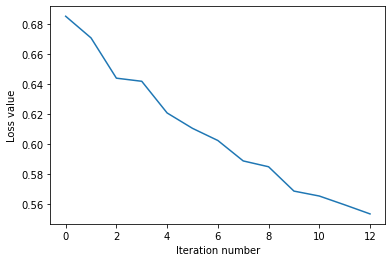

In [73]:
# Plot discriminator loss history
plt.plot(disc_loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

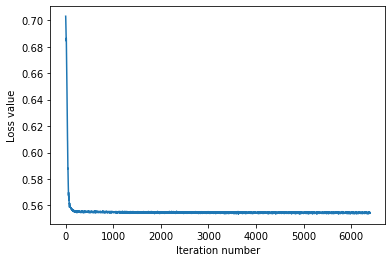

In [74]:
# Plot generator loss history
plt.plot(gen_loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### 3.2.2. Classifier Training
We will be using the GAN to synthesize data for unseen classes and train the classifier with that.

In [75]:
class Classifier(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(Classifier, self).__init__()
    self.model = nn.Sequential(
        nn.Linear(input_dim, 512),
        nn.ReLU(True),
        nn.Linear(512, 2048),
        nn.ReLU(True),
        nn.Linear(2048, output_dim),
        nn.Sigmoid()
    )

  def forward(self, e):
    y = self.model(e)
    return y

In [76]:
def train_classifier(autoencoder, generator, model, criterion, optimizer, epochs, dataloader, verbose=True):
  loss_history = [] 
  for epoch in range(epochs):
    for i, data in enumerate(dataloader, 0): 
      # Our batch:
      inputs, attrs, labels = data
      inputs = inputs.squeeze(0)
      attrs = attrs.squeeze(0)
      labels = labels.squeeze(0)
      label_indices = F.one_hot(labels, num_classes=len(all_classes))
      inputs = inputs.to(DEVICE)
      attrs = attrs.to(DEVICE)

      with torch.no_grad():
        # Drop decoded value, put encodings into inputs
        _, inputs = autoencoder(inputs)

        # Replace inputs of unseen classes by synthesized ones
        for j, batch_idx in enumerate(label_indices):
          for i, label_idx in enumerate(label_indices[j]):
            label_idx = label_idx.squeeze().item()
            if label_idx in unseen_classes:
              noise = ((torch.rand(inputs.shape[1]) - 0.5) / 0.5).unsqueeze(0).unsqueeze(0).to(DEVICE)
              attr = attrs[i].unsqueeze(0)
              fake_encodings = generator(attr, noise)
              inputs[i] = fake_encodings

      inputs = inputs.to(DEVICE)
      labels = labels.to(torch.float32).to(DEVICE)
      # zero the gradients as PyTorch accumulates them
      optimizer.zero_grad()
      # Obtain the scores
      outputs = model(inputs)
      # Calculate loss
      loss = criterion(outputs.to(DEVICE), labels.to(torch.int64))
      # Backpropagate
      loss.backward()
      # Update the weights
      optimizer.step()
      loss_history.append(loss.item())
    
    if verbose: print(f'Epoch {epoch} / {epochs}: avg. loss of last 5 iterations {np.sum(loss_history[:-6:-1])/5}')

  return loss_history

In [77]:
# Train the classifier
labels_dim = len(all_classes)
encoding_dim = 43

classifier = Classifier(encoding_dim, labels_dim)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-4, weight_decay=3e-4)

classifier = classifier.to(DEVICE)
generator = generator.to(DEVICE)
epochs = 20
classifier_trainer_loader = DataLoader(task_set, batch_size=1, shuffle=True)
classifier_loss_hist = train_classifier(
    autoencoder, generator, classifier, criterion, optimizer, epochs, classifier_trainer_loader)

Epoch 0 / 20: avg. loss of last 5 iterations 2.9864196300506594
Epoch 1 / 20: avg. loss of last 5 iterations 2.9844921112060545
Epoch 2 / 20: avg. loss of last 5 iterations 2.976469850540161
Epoch 3 / 20: avg. loss of last 5 iterations 2.971938467025757
Epoch 4 / 20: avg. loss of last 5 iterations 2.9799551010131835
Epoch 5 / 20: avg. loss of last 5 iterations 2.975139045715332
Epoch 6 / 20: avg. loss of last 5 iterations 2.973511981964111
Epoch 7 / 20: avg. loss of last 5 iterations 2.9783533096313475
Epoch 8 / 20: avg. loss of last 5 iterations 2.980174207687378
Epoch 9 / 20: avg. loss of last 5 iterations 2.9625845909118653
Epoch 10 / 20: avg. loss of last 5 iterations 2.9642796516418457
Epoch 11 / 20: avg. loss of last 5 iterations 2.9659432888031008
Epoch 12 / 20: avg. loss of last 5 iterations 2.974790096282959
Epoch 13 / 20: avg. loss of last 5 iterations 2.972892427444458
Epoch 14 / 20: avg. loss of last 5 iterations 2.970254898071289
Epoch 15 / 20: avg. loss of last 5 iteratio

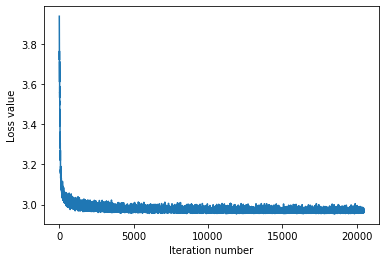

In [78]:
# Plot classifier loss history
plt.plot(classifier_loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

# 4. Analysis of the Classifier

We will be running the classifier over the test set to see its results.

In [79]:
def test_classifier(autoencoder, generator, model, criterion, optimizer, epochs, dataloader, verbose=True):
  with torch.no_grad():
    loss_history = []
    loss_history_map = defaultdict(list)
    for epoch in range(epochs):
      for i, data in enumerate(dataloader, 0):  
        # Our batch:
        inputs, attrs, label_indices, labels = data
        inputs = inputs.to(DEVICE)

        # Drop decoded value, put encodings into inputs
        _, inputs = autoencoder(inputs)

        inputs = inputs.to(DEVICE)
        labels = labels.to(torch.float32).to(DEVICE)
        # Obtain the scores
        outputs = model(inputs)
        # Calculate loss
        loss = criterion(outputs.to(DEVICE), labels)
        losses = loss.item()
        for label_idx in label_indices:
          label_idx = label_idx.squeeze().item()
          loss_history_map[label_idx].append(loss.item())
        loss_history.append(loss.item())
      
      if verbose: print(f'Epoch {epoch} / {epochs}: avg. loss of last 5 iterations {np.sum(loss_history[:-6:-1])/5}')

  return loss_history, loss_history_map

In [80]:
# Test the classifier
labels_dim = len(all_classes)
encoding_dim = 43

classifier = Classifier(encoding_dim, labels_dim)
criterion = nn.CrossEntropyLoss()

classifier = classifier.to(DEVICE)
generator = generator.to(DEVICE)
epochs = 1
classifier_test_loss_hist, classifier_test_loss_hist_map = test_classifier(
    autoencoder, generator, classifier, criterion, optimizer, epochs, test_loader)

Epoch 0 / 1: avg. loss of last 5 iterations 3.787090539932251


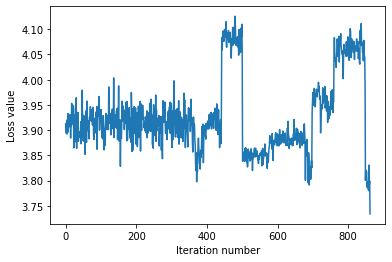

In [81]:
# Plot classifier loss history
plt.plot(classifier_test_loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [82]:
# Calculate average loss per class
seen_avg_loss_map = dict()
seen_losses = []
unseen_avg_loss_map = dict()
unseen_losses = []
for key, val in classifier_test_loss_hist_map.items():
  val = np.mean(val)
  if key in seen_classes:
    seen_avg_loss_map[key] = val
    seen_losses.append(val)
  else:
    unseen_avg_loss_map[key] = val
    unseen_losses.append(val)

print('Seen losses mean:', np.mean(seen_losses), 'standard deviation:', np.std(seen_losses), 'max:', np.max(seen_losses), 'min', np.min(seen_losses))
print('Unseen losses mean:', np.mean(unseen_losses), 'standard deviation:', np.std(unseen_losses), 'max:', np.max(unseen_losses), 'min', np.min(unseen_losses))

Seen losses mean: 3.913821505812004 standard deviation: 0.00593848726435913 max: 3.9256053450246338 min 3.9037706295245793
Unseen losses mean: 3.9139209045849923 standard deviation: 0.08892557397426519 max: 4.081586938075737 min 3.8032201988752496


# 5. Conclusion

We were not able to fully implement the paper but we approximated the overall approach. The GAN seems to be the bottleneck to better performance here.

However, there is one thing to note here. That is, we constructed the test set such that seen classes come before unseen classes. That means if we look at the graph above, classification of the unseen classes have higher variance than seen classes but can achieve better performance. 

The lows tend to be lower and the highs tend to be higher but on the average unseen classes did not perform worse than seen classes. Which should mean that we accomplished zero shot learning.

The results would have been better with hyperparameter tuning but I did not have the opportunity.